# QuTiPv5 Paper Example: QuTiP-JAX with mesolve and auto-differnetiation

Authors: Maximilian Meyer-Mölleringhof (m.meyermoelleringhof@gmail.com), Rochisha Agarwal (rochisha.agarwal2302@gmail.com), Neill Lambert (nwlambert@gmail.com)

For many years now, GPUs have been a fundamental tool for accelerating numerical tasks.
Today, many libraries enable off-the-shelf methods to leverage GPUs' potential to speed up costly calculations.
QuTiP’s flexible data layer can directly be used with many such libraries and thereby drastically reduce computation time.
Despite a big variety of frameworks, in connection to QuTiP, development has centered on the QuTiP-JAX integration [\[1\]](#References) due to JAX's robust auto-differentiation features and widespread adoption in machine learning.

In these examples we illustrate how JAX naturally integrates into QuTiP v5 [\[2\]](#References) using the QuTiP-JAX package.
As a simple first example, we look at a one-dimensional spin chain and how we might employ `mesolve()` and JAX to solve the related master equation.
In the second part, we focus on the auto-differentiation capabilities.
For this we first consider the counting statistics of an open quantum system connected to an environment.
Lastly, we look at a driven qubit system and computing the gradient of its state population in respect to the drive's frequency using `mcsolve()`.

## Introduction

In addition to the standard QuTiP package, in order to use QuTiP-JAX, the JAX package needs to be installed.
This package also comes with `jax.numpy` which mirrors all of `numpy`s functionality for seamless integration with JAX.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import qutip_jax as qj
from diffrax import PIDController, Tsit5
from jax import default_device, devices, grad, jacfwd, jacrev, jit
from qutip import (CoreOptions, about, basis, destroy, lindblad_dissipator,
                   liouvillian, mcsolve, mesolve, projection, qeye, settings,
                   sigmam, sigmax, sigmay, sigmaz, spost, spre, sprepost,
                   steadystate, tensor)

%matplotlib inline

An immediate effect of importing `qutip_jax` is the availability of the data layer formats `jax` and `jax_dia`.
They allow for dense (`jax`) and custom sparse (`jax_dia`) formats.

In [2]:
print(qeye(3, dtype="jax").dtype.__name__)
print(qeye(3, dtype="jaxdia").dtype.__name__)

JaxArray
JaxDia


In order to use the JAX data layer also within the master equation solver, there are two settings we can choose.
First, is simply adding `method: diffrax` to the options parameter of the solver.
Second, is to use the `qutip_jax.set_as_default()` method.
It automatically switches all data data types to JAX compatible versions and sets the default solver method to `diffrax`.

In [3]:
qj.set_as_default()

To revert this setting, we can set the function parameter `revert = True`.

In [4]:
# qj.set_as_default(revert = True)

## Using the GPU with JAX and Diffrax - 1D Ising Spin Chain

Before diving into the example, it is worth noting here that GPU acceleration depends heavily on the type of problem.
GPUs are good at parallelizing many small matrix-vector operations, such as integrating small systems across multiple parameters or simulating quantum circuits with repeated small matrix operations.
For a single ODE involving large matrices, the advantages are less straightforward since ODE solvers are inherently sequential.
However, as it is illustrated in the QuTiP v5 paper [\[2\]](#References), there is a cross-over point at which using JAX becomes beneficial.

### 1D Ising Spin Chain

To illustrate the usage of QuTiP-JAX, we look at the one-dimensional spin chain with the Hamiltonian

$H = \sum_{i=1}^N g_0 \sigma_z^{(n)} - \sum_{n=1}^{N-1} J_0 \sigma_x^{(n)} \sigma_x^{(n+1)}$.

We hereby consider $N$ spins that share an energy splitting of $g_0$ and have a coupling strength $J_0$.
The end of the chain connects to an environment described by a Lindbladian dissipator which we model with the collapse operator $\sigma_x^{(N-1)}$ and coupling rate $\gamma$.

As part of the [QuTiPv5 paper](#References), we see an extensive study on the computation time depending on the dimensionality $N$.
In this example we cannot replicate the performance of a supercomputer of course, so we rather focus on the correct implementation to solve the Lindblad equation for this system using JAX and `mesolve()`.

In [5]:
# system parameters
N = 4  # number of spins
g0 = 1  # energy splitting
J0 = 1.4  # coupling strength
gamma = 0.1  # dissipation rate

# simulation parameters
tlist = jnp.linspace(0, 5, 100)
opt = {
    "normalize_output": False,
    "store_states": True,
    "method": "diffrax",
    "stepsize_controller": PIDController(
        rtol=settings.core["rtol"], atol=settings.core["atol"]
    ),
    "solver": Tsit5(),
}

In [6]:
with CoreOptions(default_dtype="jaxdia"):
    # Operators for individual qubits
    sx_list, sy_list, sz_list = [], [], []
    for i in range(N):
        op_list = [qeye(2)] * N
        op_list[i] = sigmax()
        sx_list.append(tensor(op_list))
        op_list[i] = sigmay()
        sy_list.append(tensor(op_list))
        op_list[i] = sigmaz()
        sz_list.append(tensor(op_list))

    # Hamiltonian - Energy splitting terms
    H = 0.0
    for i in range(N):
        H += g0 * sz_list[i]

    # Interaction terms
    for n in range(N - 1):
        H += -J0 * sx_list[n] * sx_list[n + 1]

    # Collapse operator acting locally on single spin
    c_ops = [gamma * sx_list[N - 1]]

    # Initial state
    state_list = [basis(2, 1)] * (N - 1)
    state_list.append(basis(2, 0))
    psi0 = tensor(state_list)

    result = mesolve(H, psi0, tlist, c_ops, e_ops=sz_list, options=opt)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


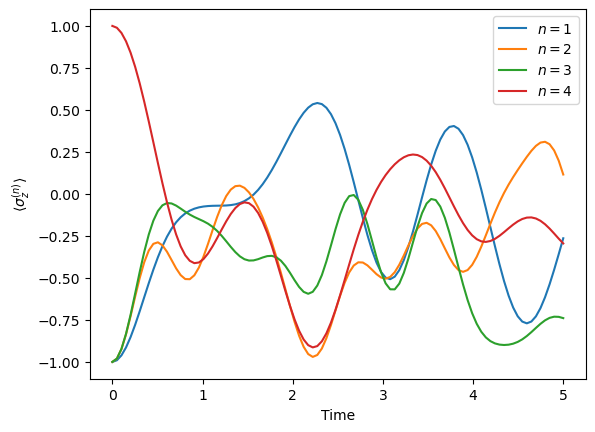

In [7]:
for i, s in enumerate(result.expect):
    plt.plot(tlist, s, label=rf"$n = {i+1}$")
plt.xlabel("Time")
plt.ylabel(r"$\langle \sigma^{(n)}_z \rangle$")
plt.legend()
plt.show()

## Auto-Differentiation

We have seen in the previous example how the new JAX data-layer in QuTiP works.
On top of that, JAX adds the features of auto-differentiation.
To compute derivatives, it is often numerical approximations (e.g., finite difference method) that need to be employed.
Especially for higher order derivatives, these methods can turn into costly and inaccurate calculations.

Auto-differentiation, on the other hand, exploits the chain rule to compute such derivatives.
The idea is that any numerical function can be expressed by elementary analytical functions and operations.
Consequently, using the chain rule, the derivatives of almost any higher-level function become accessible.

Although there are many applications for this technique, in this chapter we want to focus on two examples where auto-differentiation becomes relevant.

### Statistics of Excitations between Quantum System and Environment

We consider an open quantum system that is in contact with an evironment via a single jump operator.
Additionally, we have a measurement device that tracks the flow of excitations between the system and the environment.
The probability distribution that describes the number of such exchanged excitations $n$ in a certain time $t$ is called the full counting statistics and denoted by $P_n(t)$.
This statistics is a defining property that allows to derive many experimental observables like shot noise or current.

For the example here, we can calculate this statistics by using a modified version of the density operator and Lindblad master equation.
We introduce the *tilted* density operator $G(z,t) = \sum_n e^{zn} \rho^n (t)$ with $\rho^n(t)$ being the density operator of the system conditioned on $n$ exchanges by time $t$, so $\text{Tr}[\rho^n(t)] = P_n(t)$.
The master equation for this operator, including the jump operator $C$, is then given as

$\dot{G}(z,t) = -\dfrac{i}{\hbar} [H(t), G(z,t)] + \dfrac{1}{2} [2 e^z C \rho(t)C^\dagger - \rho C^\dagger C - C^\dagger C \rho(t)]$.

We see that for $z = 0$, this master equation becomes the regular Lindblad equation and $G(0,t) = \rho(t)$.
However, it also allows us to describe the counting statistics through its derivatives

$\langle n^m \rangle (t) = \sum_n n^m \text{Tr} [\rho^n (t)] = \dfrac{d^m}{dz^m} \text{Tr} [G(z,t)]|_{z=0}$.

These derivatives are precisely where the auto-differention by JAX finds its application for us.

In [8]:
# system parameters
ed = 1
GammaL = 1
GammaR = 1

# simulation parameters
options = {
    "method": "diffrax",
    "normalize_output": False,
    "stepsize_controller": PIDController(rtol=1e-7, atol=1e-7),
    "solver": Tsit5(scan_kind="bounded"),
    "progress_bar": False,
}

When working with JAX you can choose the type of device / processor to be used.
In our case, we will resort to the CPU since this is a simple Jupyter Notebook.
However, when running this on your machine, you can opt for using your GPU by simpy changing the argument below.

In [9]:
with default_device(devices("cpu")[0]):
    with CoreOptions(default_dtype="jaxdia"):
        d = destroy(2)
        H = ed * d.dag() * d
        c_op_L = jnp.sqrt(GammaL) * d.dag()
        c_op_R = jnp.sqrt(GammaR) * d

        L0 = (
            liouvillian(H)
            + lindblad_dissipator(c_op_L)
            - 0.5 * spre(c_op_R.dag() * c_op_R)
            - 0.5 * spost(c_op_R.dag() * c_op_R)
        )
        L1 = sprepost(c_op_R, c_op_R.dag())

        rho0 = steadystate(L0 + L1)

        def rhoz(t, z):
            L = L0 + jnp.exp(z) * L1  # jump term
            tlist = jnp.linspace(0, t, 50)
            result = mesolve(L, rho0, tlist, options=options)
            return result.final_state.tr()

        # first derivative
        drhozdz = jacrev(rhoz, argnums=1)
        # second derivative
        d2rhozdz = jacfwd(drhozdz, argnums=1)

In [10]:
tf = 100
Itest = GammaL * GammaR / (GammaL + GammaR)
shottest = Itest * (1 - 2 * GammaL * GammaR / (GammaL + GammaR) ** 2)
ncurr = drhozdz(tf, 0.0) / tf
nshot = (d2rhozdz(tf, 0.0) - drhozdz(tf, 0.0) ** 2) / tf

print("===== RESULTS =====")
print("Analytical current", Itest)
print("Numerical current", ncurr)
print("Analytical shot noise (2nd cumulant)", shottest)
print("Numerical shot noise (2nd cumulant)", nshot)

===== RESULTS =====
Analytical current 0.5
Numerical current 0.5000000000000002
Analytical shot noise (2nd cumulant) 0.25
Numerical shot noise (2nd cumulant) 0.2512499999999909


### Driven One Qubit System & Frequency Optimization

As a second example for auto differentiation, we consider the driven Rabi model, which is given by the time-dependent Hamiltonian

$H(t) = \dfrac{\hbar \omega_0}{2} \sigma_z + \dfrac{\hbar \Omega}{2} \cos (\omega t) \sigma_x$

with the energy splitting $\omega_0$, $\Omega$ as the Rabi frequency, the drive frequency $\omega$ and $\sigma_{x/z}$ are Pauli matrices.
When we add dissipation to the system, the dynamics is given by the Lindblad master equation, which introduces collapse operator $C = \sqrt{\gamma} \sigma_-$ to describe energy relaxation.

For this example, we are interested in the population of the excited state of the qubit

$P_e(t) = \bra{e} \rho(t) \ket{e}$

and its gradient with respect to the frequency $\omega$.

We want to optimize this quantity by adjusting the drive frequency $\omega$.
To achieve this, we compute the gradient of $P_e(t)$ in respect to $\omega$ by using JAX's auto-differentiation tools and QuTiP's `mcsolve()`.

In [11]:
# system parameters
gamma = 0.1  # dissipation rate

In [12]:
# time dependent drive
@jit
def driving_coeff(t, omega):
    return jnp.cos(omega * t)


# system Hamiltonian
def setup_system():
    H_0 = sigmaz()
    H_1 = sigmax()
    H = [H_0, [H_1, driving_coeff]]
    return H

In [13]:
# simulation parameters
psi0 = basis(2, 0)
tlist = jnp.linspace(0.0, 10.0, 100)
c_ops = [jnp.sqrt(gamma) * sigmam()]
e_ops = [projection(2, 1, 1)]

In [14]:
# Objective function: returns final exc. state population
def f(omega):
    H = setup_system()
    arg = {"omega": omega}
    result = mcsolve(H, psi0, tlist, c_ops, e_ops=e_ops, ntraj=100, args=arg)
    return result.expect[0][-1]

In [15]:
# Gradient of the excited state population with respect to omega
grad_f = grad(f)(2.0)

10.0%. Run time:  13.62s. Est. time left: 00:00:02:02


20.0%. Run time:  22.92s. Est. time left: 00:00:01:31


30.0%. Run time:  31.68s. Est. time left: 00:00:01:13


40.0%. Run time:  39.52s. Est. time left: 00:00:00:59


50.0%. Run time:  48.63s. Est. time left: 00:00:00:48


60.0%. Run time:  58.68s. Est. time left: 00:00:00:39


70.0%. Run time:  66.59s. Est. time left: 00:00:00:28


80.0%. Run time:  74.51s. Est. time left: 00:00:00:18


90.0%. Run time:  84.13s. Est. time left: 00:00:00:09


100.0%. Run time:  92.01s. Est. time left: 00:00:00:00


Total run time:  92.79s


In [16]:
print(grad_f)

0.9827381544715896


## References



[1] [QuTiP-JAX](https://github.com/qutip/qutip-jax)

[2] [QuTiP 5: The Quantum Toolbox in Python](https://arxiv.org/abs/2412.04705)

## About

In [17]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

## Testing

In [18]:
assert jnp.isclose(Itest, ncurr, rtol=1e-5), "Current calc. deviates"
assert jnp.isclose(shottest, nshot, rtol=1e-1), "Shot noise calc. deviates."